In [6]:
# Standard libraries
from copy import deepcopy

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from scipy.stats import mannwhitneyu, wilcoxon, binom_test

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.plotting import imshow, stat_annot_patches
from mesostat.utils.pandas_helper import get_rows_colvals

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.table_lib as table_lib
from src.lib.metric_wrapper import metric_by_selector_all, metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
import src.lib.tests_phase_signle_cell as single_cell_tests
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-neuro/chernysheva-tmaze-analysis-2020
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
# params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
# params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 1. Neuron-Time-Average

**Goal**: Attempt to predict phase from mean activity over trial

# 2 Time-Average

**Goal**: Attempt to predict phase from average activities of individual cells.
* Count predictive cells in each mouse
* Test overlap over phases/intervals - identify how many significant cells overlap

## 2.1 avg-firing-rate by neuron
 -> heatmap by mouse | 1D plot by neurons

In [28]:
def plot_avg_firing_rate_by_neuron(datatype, phaseType, haveWaiting=True):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    for mousename in sorted(dataDB.mice):
        fig, ax = plt.subplots(ncols=4, figsize=(4*2, 6), tight_layout=True)
        fig.suptitle(mousename)
        iCol = 0

        for performance in dataDB.get_performances():
            if phaseType != 'phase':
                boundingLines = dataDB.get_phase_bounding_lines(phaseType, performance, haveWaiting=haveWaiting)

            for direction in dataDB.get_directions():
                queryDict = {'datatype' : datatype, 'mousename' : mousename, 'performance' : performance, 'direction' : direction}
                means = metric_by_selector_all(dataDB, queryDict, phaseType, 'mean', 'p', settings, haveWaiting=haveWaiting)                
                means = means.T
                
                print(means.shape)

                # Sort by max argument
                # But only based on the first one (CL) so that all 4 combinations have the same sorting
                if iCol == 0:
                    idxsMaxArgs = np.argsort(np.array([np.argmax(m) for m in means]))
                means = means[idxsMaxArgs]

                title = direction[0] + performance[0]
                imshow(fig, ax[iCol], means, limits=None, title=title, haveColorBar=True)
                if phaseType != 'phase':
                    for bline in boundingLines:
                        ax[iCol].axvline(x=bline-1, linestyle='--', color='r', alpha=0.5)

                iCol += 1

        plt.savefig(mousename + '_avgrate_' + phaseType + '.pdf')
        plt.close()

### 2.1.1 avg-firing-rate by neuron and interval

In [36]:
plot_avg_firing_rate_by_neuron('zscore', 'interval', haveWaiting=False)

(88, 14)
(88, 14)
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found 

### 2.1.2 avg-firing-rate by neuron and phase

In [37]:
plot_avg_firing_rate_by_neuron('zscore', 'phase', haveWaiting=False)

(88, 3)
(88, 3)
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
(88, 3)
(88, 3)
(46, 3)
(46, 3)
(46, 3)
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
(46, 3)
(83, 3)
(83, 3)
(83, 3)
(83, 3)
(47, 3)
(47, 3)
(47, 3)
(47, 3)
(49, 3)
(49, 3)
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping


In [38]:
plot_avg_firing_rate_by_neuron('zscore', 'semiphase', haveWaiting=False)

(88, 10)
(88, 10)
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
(88, 8)
(88, 8)
(46, 10)
(46, 10)
(46, 8)
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061

## 2.2 significant-avg-firing-rate by neuron

In [46]:
def plot_significant_firing_rate_by_neuron(datatype, phaseType, confThr=0.01, haveWaiting=True):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    performanceValues = dataDB.get_performances()
    directionValues = dataDB.get_directions()
    
    if phaseType == 'phase':
        performanceValues += ['All']
        directionValues += ['All']
        
    nCol = len(performanceValues) * len(directionValues)
    cumulConfDict = {}
    
    for mousename in sorted(dataDB.mice):
        print('doing mouse', mousename)
        nChannel = dataDB.get_nchannel(mousename, datatype)

        fig1, ax1 = plt.subplots(ncols=nCol, figsize=(nCol*2, 6), tight_layout=True)
        fig2, ax2 = plt.subplots(ncols=nCol, figsize=(nCol*4, 4), tight_layout=True)

        fig1.suptitle(mousename)
        fig2.suptitle(mousename)
        iCol = 0

        for performance in performanceValues:
            if phaseType != 'phase':
                boundingLines = dataDB.get_phase_bounding_lines(phaseType, performance, haveWaiting=haveWaiting)
                    
            for direction in directionValues:
                queryDict = {'datatype' : datatype, 'mousename' : mousename}
                if performance != 'All':
                    queryDict = {**queryDict, **{'performance' : performance}}
                if direction != 'All':
                    queryDict = {**queryDict, **{'direction' : direction}}
                    
                # Calculate p-values
                pVals2D = single_cell_tests.test_inverse_all_selectors(dataDB, queryDict, phaseType, metricName='mean', alternative="greater", haveWaiting=haveWaiting, settings=settings)
                negLogPVals2D = -np.log10(pVals2D)
                
                # Calculate significant cells and confusion matrix
                signCellsByPhase = single_cell_tests.pvalues_2_significant_cells(pVals2D, confThr)
                confMat = single_cell_tests.significance_confusion_matrix(signCellsByPhase) / nChannel

                # Sort by max argument
                # But only based on the first one (CL) so that all 4 combinations have the same sorting
                if iCol == 0:
                    idxsMaxArgs = np.argsort(np.array([np.argmax(p) for p in negLogPVals2D]))
                negLogPVals2D = negLogPVals2D[idxsMaxArgs]

                title = direction[0] + performance[0]
                if phaseType != 'phase':
                    imshow(fig1, ax1[iCol], negLogPVals2D, limits=[0, 4], title=title, haveColorBar=True, cmap='viridis')
                    for bline in boundingLines:
                        ax1[iCol].axvline(x=bline-1, linestyle='--', color='r', alpha=0.5)
                else:
                    imshow(fig1, ax1[iCol], negLogPVals2D, limits=[0, 4], title=title, haveColorBar=False, cmap='viridis')

                # Plot confusion matrix
                imshow(fig2, ax2[iCol], confMat, limits=[0, 1], title=title, haveColorBar=True, cmap='jet')
                if phaseType != 'phase':
                    for bline in boundingLines:
                        ax2[iCol].axvline(x=bline-1, linestyle='--', color='r', alpha=0.5)
                        ax2[iCol].axhline(y=bline-1, linestyle='--', color='r', alpha=0.5)
                
                # Store confusion matrices 
                cumulConfDict[(mousename, direction, performance)] = confMat
                
                iCol += 1

        fig1.savefig(mousename + '_significantrate_' + phaseType + '.pdf')
        plt.close()
        fig2.savefig(mousename + '_significantrate_' + phaseType + '_confusion.pdf')
        plt.close()

    iCol = 0
    figAll, axAll = plt.subplots(ncols=nCol, figsize=(nCol*4, 4), tight_layout=True)    
    for performance in performanceValues:
        for direction in directionValues:
            confThisCondition = [cumulConfDict[(mousename, direction, performance)] for mousename in dataDB.mice]
            confAvg = np.mean(confThisCondition, axis=0)
            
            title = direction[0] + performance[0]
            imshow(figAll, axAll[iCol], confAvg, limits=[0, 1], title=title, haveColorBar=True, cmap='jet')
            
            iCol += 1
            
    figAll.savefig('Allmice_significantrate_' + phaseType + '_confusion.pdf')
    plt.close()

### 2.2.1 significant-avg-firing-rate by neuron and interval

In [50]:
plot_significant_firing_rate_by_neuron('raw', 'interval', confThr=0.01, haveWaiting=False)

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found f

### 2.2.2 significant-avg-firing-rate by neuron and phase

In [51]:
plot_significant_firing_rate_by_neuron('deconv', 'phase', confThr=0.01, haveWaiting=False)

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No 

In [52]:
plot_significant_firing_rate_by_neuron('deconv', 'semiphase', confThr=0.01, haveWaiting=False)

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No 

In [14]:
def plot_df_count_by_mice(ax, data1, data2, label1, label2, xLabels, nCellPerMouse):
    dataNorm1 = np.array(data1) / np.array(nCellPerMouse)
    dataNorm2 = np.array(data2) / np.array(nCellPerMouse)
    pVals = [binom_test(d1, d1 + d2) for d1, d2 in zip(data1, data2)]
    
    xInd = np.arange(len(xLabels))
    width = 0.35  # the width of the bars
    
    rects1 = ax.bar(xInd - width/2, dataNorm1, width, label=label1)
    rects2 = ax.bar(xInd + width/2, dataNorm2, width, label=label2)
    
    for patch1, patch2, pVal in zip(rects1.patches, rects2.patches, pVals):
        stat_annot_patches(ax, patch1, patch2, pVal, fontsize=20)
    
    ax.set_xticks(xInd)
    ax.set_xticklabels(xLabels)


def plot_save_significantly_firing_neurons(datatype, phaseType, exclusiveIndices, exclusiveLabels, ranges=None, confThr=0.01, haveAll=False):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    significantCellsDict = {label : [] for label in exclusiveLabels}
    
    if not haveAll:
        performanceValues = ['Correct', 'Mistake']
        directionValues = ['L', 'R']
    else:
        performanceValues = ['Correct', 'Mistake', 'All']
        directionValues = ['L', 'R', 'All']
    
    mice = list(sorted(dataDB.mice))
    for mousename in mice:
        print('doing mouse', mousename)

        for performance in performanceValues:
            for direction in directionValues:
                queryDict = {'datatype' : datatype, 'mousename' : mousename}
                if performance != 'All':
                    queryDict = {**queryDict, **{'performance' : performance}}
                if direction != 'All':
                    queryDict = {**queryDict, **{'direction' : direction}}
                    
                # Calculate p-values and significant cells
                pVals2D = single_cell_tests.test_inverse_all_selectors(dataDB, queryDict, phaseType, metricName='mean', alternative="greater", settings=settings, ranges=ranges)
                signCellsByPhase = single_cell_tests.pvalues_2_significant_cells(pVals2D, confThr)

                # Determine maintenance-significant cells for storage
                exclusiveSets = single_cell_tests.find_exclusive_sets(signCellsByPhase, exclusiveIndices)

                for thisSet, thisLabel in zip(exclusiveSets, exclusiveLabels):
                    significantCellsDict[thisLabel] += [[mousename, performance, direction, np.array(list(thisSet))]]

    # Store significant cells in HDF5
    significantCellsDFDict = {}
    for label, signCellsData in significantCellsDict.items():
        dfCells = pd.DataFrame(signCellsData, columns=['mousename', 'performance', 'direction', 'cells'])
        dfCells.to_hdf('significant_cells_' + datatype + '_' + label + '.h5', key='df', mode='w')
        significantCellsDFDict[label] = dfCells
        
    nCellPerMouse = np.array([dataDB.get_nchannel(mousename, datatype) for mousename in mice])

    # Plot selector-specific number of significant cells vs mice
    for performance in performanceValues:
        for direction in directionValues:
            figCount, axCount = plt.subplots(figsize=(5, 5))
            queryDict = {"performance" : performance, "direction" : direction}
            
            nSignCellByMouse = []
            for label, signCellsDF in significantCellsDFDict.items():
                rows = get_rows_colvals(signCellsDF, queryDict, dropQuery=True)
                nSignCellByMouse += [[len(list(row.values)[1]) for idx, row in rows.iterrows()]]
                    
            plot_df_count_by_mice(axCount, *nSignCellByMouse, *exclusiveLabels, mice, nCellPerMouse)
                
            axCount.legend()
            figCount.savefig('significantrate_by_mouse_' + phaseType + '_' + performance + '_' + direction + '.pdf')
            plt.close()

In [15]:
# Testing each phase vs remainder of the trial, storing maintenance vs encoding+retrieval
plot_save_significantly_firing_neurons('deconv', 'phase', [[1], [0, 2]], ['mt', 'enc_ret'], confThr=0.01, haveAll=True)

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No 

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['mousename', 'performance', 'direction', 'cells']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [20]:
plot_save_significantly_firing_neurons('deconv',
                                       'interval', 
                                       [[0], [1]],
                                       ['enc_base', 'enc_reward'],
                                       confThr=0.01,
                                       ranges=[2, 4],
                                       haveAll=True)

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
doing mouse m065
doing mouse m066
doing mouse m067
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
doing mouse m068


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['mousename', 'performance', 'direction', 'cells']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# 3.1 Table - Discriminate Phases by Metric

In [76]:
%%time
dataDB.verbose = False

phases = ['Encoding', 'Maintenance', 'Retrieval']
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
settings = {"serial" : True, "metricSettings" :{"max_lag" : 1}}
sweepDict = {
    #"mousename" : sorted(list(dataDB.mice)),
    "datatype": ["deconv"],#, "raw", "high", "deconv"],
    "performance": ["Correct", "Mistake", "All"],
    "direction": ["L", "R", "All"]
}

table_lib.table_discriminate_time(dataDB, sweepDict,
                                         {"phase" : phases},
                                         "mean",
                                         trgDimOrder="r",
                                         settings=settings, multiplexKey="mousename")

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,-logp(Encoding->Maintenance),-logp(Encoding->Retrieval),-logp(Maintenance->Retrieval),datatype,direction,mu(Encoding),mu(Maintenance),mu(Retrieval),performance
0,55.531562,6.443534,44.465628,deconv,L,0.093600,0.108503,0.095234,Correct
1,46.068609,4.222931,55.802194,deconv,R,0.094664,0.107258,0.093210,Correct
2,104.406926,1.082599,101.464385,deconv,All,0.094172,0.107855,0.094119,Correct
3,9.433888,2.648392,9.683933,deconv,L,0.093412,0.103304,0.101021,Mistake
4,11.488221,0.959148,9.425279,deconv,R,0.097133,0.106722,0.101470,Mistake
5,22.488359,4.276679,19.137695,deconv,All,0.095778,0.105815,0.101438,Mistake
6,66.608633,6.542077,48.924301,deconv,L,0.093775,0.107638,0.096599,All
7,59.624177,3.060283,65.579054,deconv,R,0.095152,0.107188,0.094891,All
8,129.028595,1.457359,114.933201,deconv,All,0.094506,0.107366,0.095687,All


CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 3.38 s


# 3.2 Violins - Metric by Phase and Interval

In [8]:
def plot_violins(datatype, phaseType, metricName, settings, haveWaiting=True, signCellsMouseDict=None):
    for performance in ["Correct", "Mistake"]:
        fig, ax = plt.subplots(ncols=3, figsize=(15,5))
        fig.suptitle(performance)

        intervalOrigIndices = dataDB.get_phasetype_keys(phaseType, performance)
        boundingLines = dataDB.get_phase_bounding_lines(phaseType, performance, haveWaiting=haveWaiting) - 1
        phases = dataDB.get_phasetype_keys('phase', performance, haveWaiting=haveWaiting)

        for mousename in sorted(dataDB.mice)[:-1]:
            queryThis = {"datatype" : datatype, "mousename" : mousename, "performance" : performance}  # "direction" : "R"
            rez2D = metric_by_selector_all(dataDB, queryThis, phaseType, metricName, 'p', settings, haveWaiting=haveWaiting, channelFilter=signCellsMouseDict)
    #         rez2D = rez2D[..., 0]
            plots_lib.plot_labeled_bars(ax[0], rez2D, intervalOrigIndices, plotLabel=mousename, alpha=0.2, vlines=boundingLines)

        rez2DIntervAll = metric_by_selector_all(dataDB, queryThis, phaseType, metricName, 'p', settings, haveWaiting=haveWaiting, channelFilter=signCellsMouseDict)
        rez2DPhaseAll = metric_by_selector_all(dataDB, queryThis, 'phase', metricName, 'p', settings, haveWaiting=haveWaiting, channelFilter=signCellsMouseDict)
        plots_lib.plot_labeled_bars(ax[1], rez2DIntervAll, intervalOrigIndices, vlines=boundingLines)        
        plots_lib.plot_labeled_violins(ax[2], rez2DPhaseAll, phases, "phase", metricName, joinMeans=True, printLogP=True)

        ax[0].legend()
        plt.savefig('phase_'+phaseType+'_avg_violins_'+performance+'.pdf')
        plt.show()

array([[0.  , 4.71, 2.89],
       [4.71, 0.  , 4.17],
       [2.89, 4.17, 0.  ]])

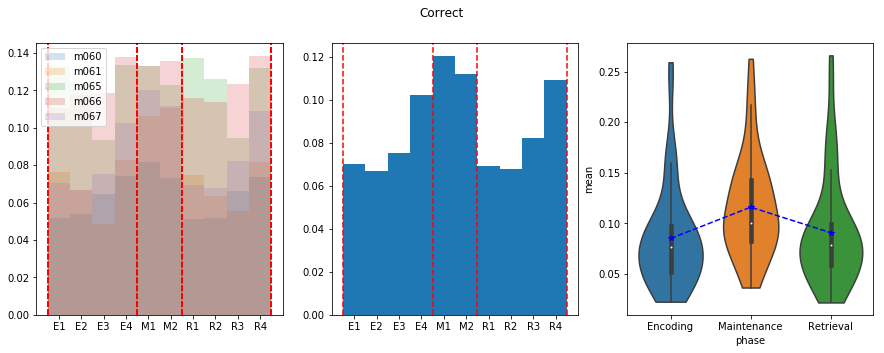

array([[0.  , 4.41, 1.8 ],
       [4.41, 0.  , 3.26],
       [1.8 , 3.26, 0.  ]])

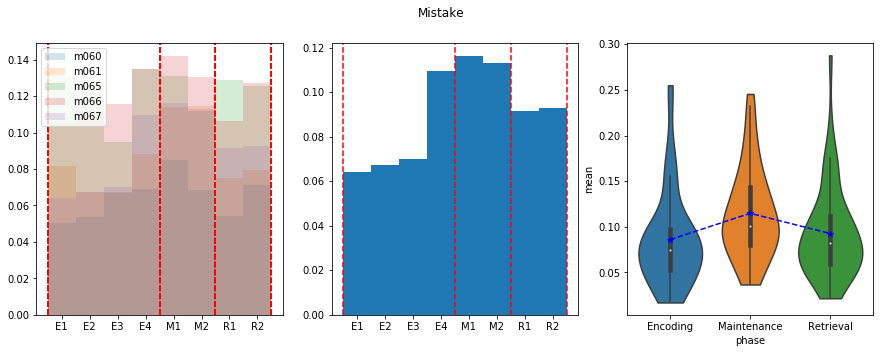

In [9]:
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
        
plot_violins("deconv", "semiphase", "mean", settings, haveWaiting=False)

## 3.2.2 Specifically for significant cells

In [21]:
signCellsMaintenance = SignificantCells('significant_cells_deconv_mt.h5').get_cells_by_mouse()
print("Maintenance cells")
print(signCellsMaintenance)


# nCellsByMouse = {mousename : dataDB.get_nchannel(mousename, 'raw') for mousename in sorted(dataDB.mice)}
signCellsReward = SignificantCells('significant_cells_deconv_enc_reward.h5').get_cells_by_mouse()
print("Reward cells")
print(signCellsReward)

significantCellsSelector = {
    'None' : None,
    'Maintenance' : signCellsMaintenance,
    'Reward' : signCellsReward
}

Maintenance cells
{'m060': array([ 0,  3,  4,  5,  6,  7,  9, 10, 11, 14, 16, 18, 19, 20, 21, 23, 24,
       26, 27, 29, 30, 31, 32, 35, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50,
       52, 55, 56, 57, 58, 60, 63, 64, 65, 67, 71, 74, 79, 80, 81, 82, 83,
       85]), 'm061': array([ 6,  7,  9, 11, 13, 14, 18, 19, 20, 21, 24, 26, 27, 28, 29, 32, 33,
       34, 35, 36, 37, 39, 40, 42, 43, 44]), 'm065': array([ 4,  6,  9, 10, 12, 13, 14, 15, 16, 19, 22, 25, 26, 30, 31, 32, 34,
       36, 38, 39, 41, 45, 46, 47, 51, 53, 54, 55, 57, 58, 59, 60, 65, 66,
       68, 69, 70, 71, 72, 73, 76, 78, 79]), 'm066': array([ 1,  2,  3,  4,  7,  8, 12, 13, 18, 21, 25, 27, 30, 31, 32, 34, 36,
       40, 41, 42, 45, 46]), 'm067': array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 16, 17, 18, 19, 20,
       21, 22, 23, 26, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43,
       44, 45, 47, 48]), 'm068': array([ 3,  5, 10, 12, 14, 16, 19, 23, 24, 26, 27])}
Reward cells
{'m060': array([ 1,  2,  7, 11, 15,

Significant Cells : None


array([[0.  , 4.71, 2.89],
       [4.71, 0.  , 4.17],
       [2.89, 4.17, 0.  ]])

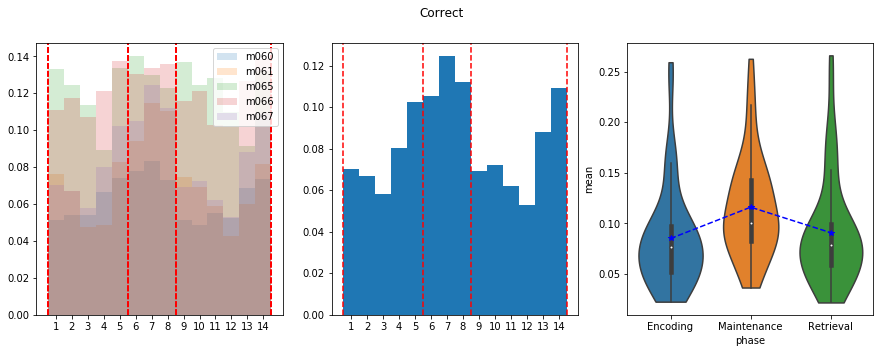

array([[0.  , 4.41, 1.8 ],
       [4.41, 0.  , 3.26],
       [1.8 , 3.26, 0.  ]])

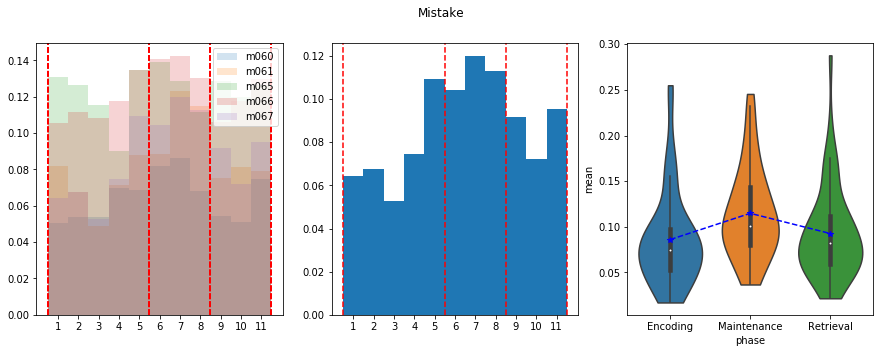

Significant Cells : Maintenance


array([[0.  , 7.11, 3.95],
       [7.11, 0.  , 7.08],
       [3.95, 7.08, 0.  ]])

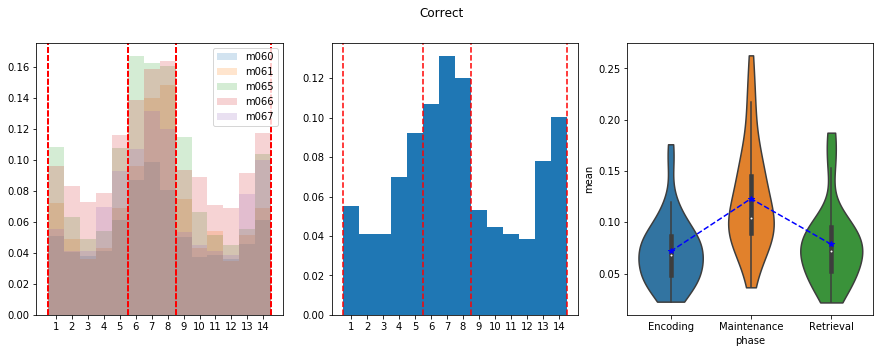

array([[0.  , 6.77, 2.62],
       [6.77, 0.  , 5.38],
       [2.62, 5.38, 0.  ]])

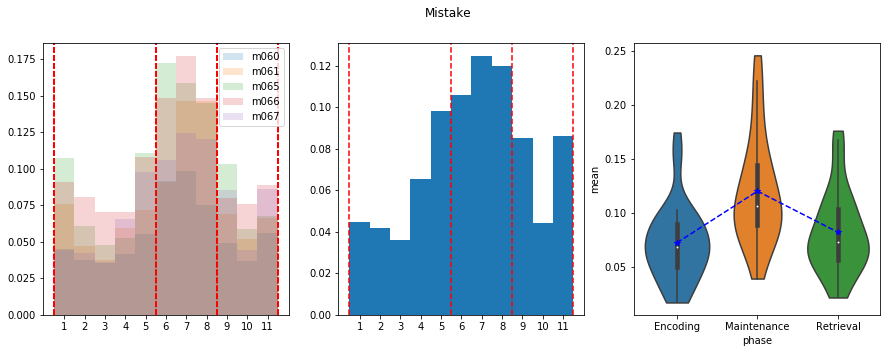

Significant Cells : Reward


array([[0.  , 0.71, 2.33],
       [0.71, 0.  , 0.46],
       [2.33, 0.46, 0.  ]])

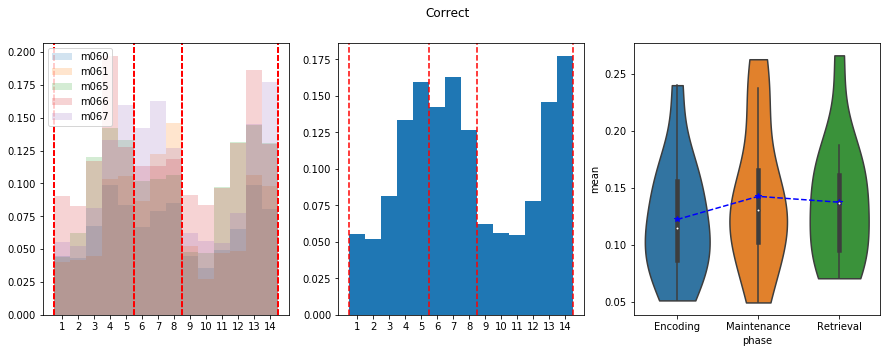

array([[0.  , 0.46, 0.12],
       [0.46, 0.  , 0.65],
       [0.12, 0.65, 0.  ]])

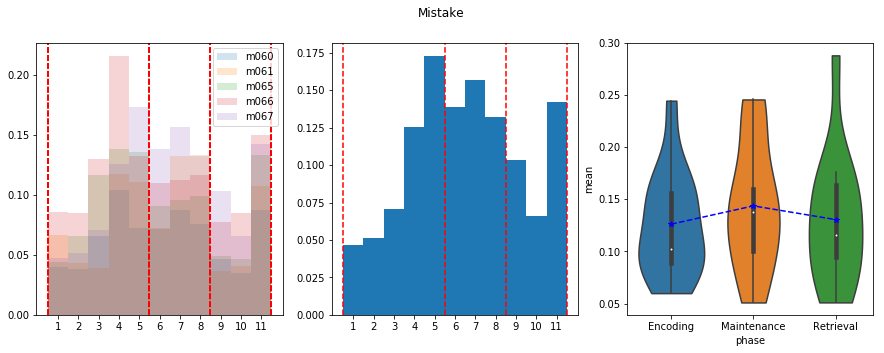

In [22]:
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
        
for signCellsName, signCells in significantCellsSelector.items():
    print("Significant Cells :", signCellsName)
    plot_violins("deconv", "interval", "mean", settings, haveWaiting=False, signCellsMouseDict=signCells)